## Imports

In [1]:
import torch
from torch import nn

from torchinfo import summary

import torchvision

import numpy as np

import matplotlib.pyplot as plt

import random
from pathlib import Path
from PIL import Image

from IPython.display import display, HTML

## Settings

In [2]:
VARIANT = "A" # Вариант - модели (для разделения моделей с разными гиперпараметрами) result/VARIANT+SEED/
SEED = 451 # Для получения предсказуемых результатов

## Global variables

In [3]:
MODEL_NAME = "base_dcgan"

DEVICE = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
# DEVICE = torch.device("cpu")
torch.set_default_device(DEVICE)

LATENT_DIM = 100
BATCH_SIZE = 256
DROPOUT_P = 0.2

# Пути для сохранения
SAVE_DIR = "./result"
DATA_DIR = "./data"

RESULT_DIR = f"{SAVE_DIR}/{MODEL_NAME}/{VARIANT}{SEED}"
GIF_DIR = f"{RESULT_DIR}/gif"

Path(RESULT_DIR).mkdir(parents=True, exist_ok=True)
Path(GIF_DIR).mkdir(parents=True, exist_ok=True)

In [4]:
if str(DEVICE) == 'cuda':
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

## Utils

In [5]:
def load_models():
     """Загрузка моделей"""
     generator.load_state_dict(
         torch.load(f"{RESULT_DIR}/generator.pth")
     )
     discriminator.load_state_dict(
         torch.load(f"{RESULT_DIR}/discriminator.pth")
     )

In [6]:
def create_gif(
    image_paths,
    output_path,
    duration_ms = 500,
    loop = 0,
    optimize = True
):
    if not image_paths:
        raise ValueError("image_paths cannot be empty")

    frames = []
    for p in image_paths:
        im = Image.open(p).convert("P", palette=Image.ADAPTIVE)
        frames.append(im)

    first, *rest = frames
    first.save(
        output_path,
        save_all=True,
        append_images=rest,
        duration=duration_ms,
        loop=loop,
        optimize=optimize,
        disposal=2
    )


In [7]:
def plot_res_64(imgs, label, title, figsize=(20, 16)):
    fig, axs = plt.subplots(8, 8, figsize=figsize)
    axs = [axs[i//8][i % 8] for i in range(64)]

    for ax, img, pred in zip(axs, imgs, label):
        ax.imshow(img[0], cmap='gray', vmin=0, vmax=1)
        ax.set_title(f'{pred:.4f}', fontsize=10, pad=2)
        ax.axis('off')

    plt.suptitle(f'{title}',
                 fontsize=20, fontweight='bold', y=0.95)

    plt.plot()

## Info

In [8]:
print(f"device: {DEVICE}")

device: cuda


## Models

In [9]:
n = 32
class BasicGenerator(nn.Module):
    def __init__(self, latent_dim=100):
        super(BasicGenerator, self).__init__()
        self.model = nn.Sequential(
            
            nn.ConvTranspose2d(latent_dim, n*4, kernel_size=7, stride=1, padding=0, bias=False),
            nn.ReLU(),
            
            nn.ConvTranspose2d(n*4, n*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n*2),
            nn.ReLU(),

            nn.ConvTranspose2d(n*2, n*2, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n*2),
            nn.ReLU(),

            nn.ConvTranspose2d(n*2, n, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n),
            nn.ReLU(),

            nn.ConvTranspose2d(n, n, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n),
            nn.ReLU(),

            nn.ConvTranspose2d(n, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)

class BasicDiscriminator(nn.Module):
    def __init__(self):
        super(BasicDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, n, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Dropout2d(DROPOUT_P),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n, n*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n*2),
            nn.Dropout2d(DROPOUT_P),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(n*2, n*2, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n*2),
            nn.Dropout2d(DROPOUT_P),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(n*2, n*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n*4),
            nn.Dropout2d(DROPOUT_P),
            nn.LeakyReLU(0.2),

             nn.Conv2d(n*4, n*4, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n*4),
            nn.Dropout2d(DROPOUT_P),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(n*4, 1, kernel_size=7, stride=1, padding=0),
        )
    
    def forward(self, x):
        return self.model(x)

In [10]:
generator = BasicGenerator(latent_dim=LATENT_DIM)
sm_g = summary(generator, input_size=(1, LATENT_DIM, 1, 1), device=DEVICE)
sm_g

Layer (type:depth-idx)                   Output Shape              Param #
BasicGenerator                           [1, 1, 28, 28]            --
├─Sequential: 1-1                        [1, 1, 28, 28]            --
│    └─ConvTranspose2d: 2-1              [1, 128, 7, 7]            627,200
│    └─ReLU: 2-2                         [1, 128, 7, 7]            --
│    └─ConvTranspose2d: 2-3              [1, 64, 14, 14]           131,072
│    └─BatchNorm2d: 2-4                  [1, 64, 14, 14]           128
│    └─ReLU: 2-5                         [1, 64, 14, 14]           --
│    └─ConvTranspose2d: 2-6              [1, 64, 14, 14]           36,864
│    └─BatchNorm2d: 2-7                  [1, 64, 14, 14]           128
│    └─ReLU: 2-8                         [1, 64, 14, 14]           --
│    └─ConvTranspose2d: 2-9              [1, 32, 28, 28]           32,768
│    └─BatchNorm2d: 2-10                 [1, 32, 28, 28]           64
│    └─ReLU: 2-11                        [1, 32, 28, 28]         

In [11]:
discriminator = BasicDiscriminator()
sm_d = summary(discriminator, input_size=(1, 1, 28, 28), device=DEVICE)
sm_d

Layer (type:depth-idx)                   Output Shape              Param #
BasicDiscriminator                       [1, 1, 1, 1]              --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           288
│    └─Dropout2d: 2-2                    [1, 32, 28, 28]           --
│    └─LeakyReLU: 2-3                    [1, 32, 28, 28]           --
│    └─Conv2d: 2-4                       [1, 64, 14, 14]           32,768
│    └─BatchNorm2d: 2-5                  [1, 64, 14, 14]           128
│    └─Dropout2d: 2-6                    [1, 64, 14, 14]           --
│    └─LeakyReLU: 2-7                    [1, 64, 14, 14]           --
│    └─Conv2d: 2-8                       [1, 64, 14, 14]           36,864
│    └─BatchNorm2d: 2-9                  [1, 64, 14, 14]           128
│    └─Dropout2d: 2-10                   [1, 64, 14, 14]           --
│    └─LeakyReLU: 2-11                   [1, 64, 14, 14]           --
│   

## Load model

In [12]:
load_models()
generator.eval()
discriminator.eval()
print('load')

load


## Create gif

In [13]:
pngs = list(Path(GIF_DIR).glob("*.png"))
create_gif(pngs, RESULT_DIR + "/res.gif")

In [14]:
display(HTML(f'<img src="{RESULT_DIR}/res.gif" width="700">'))

## Vizualization

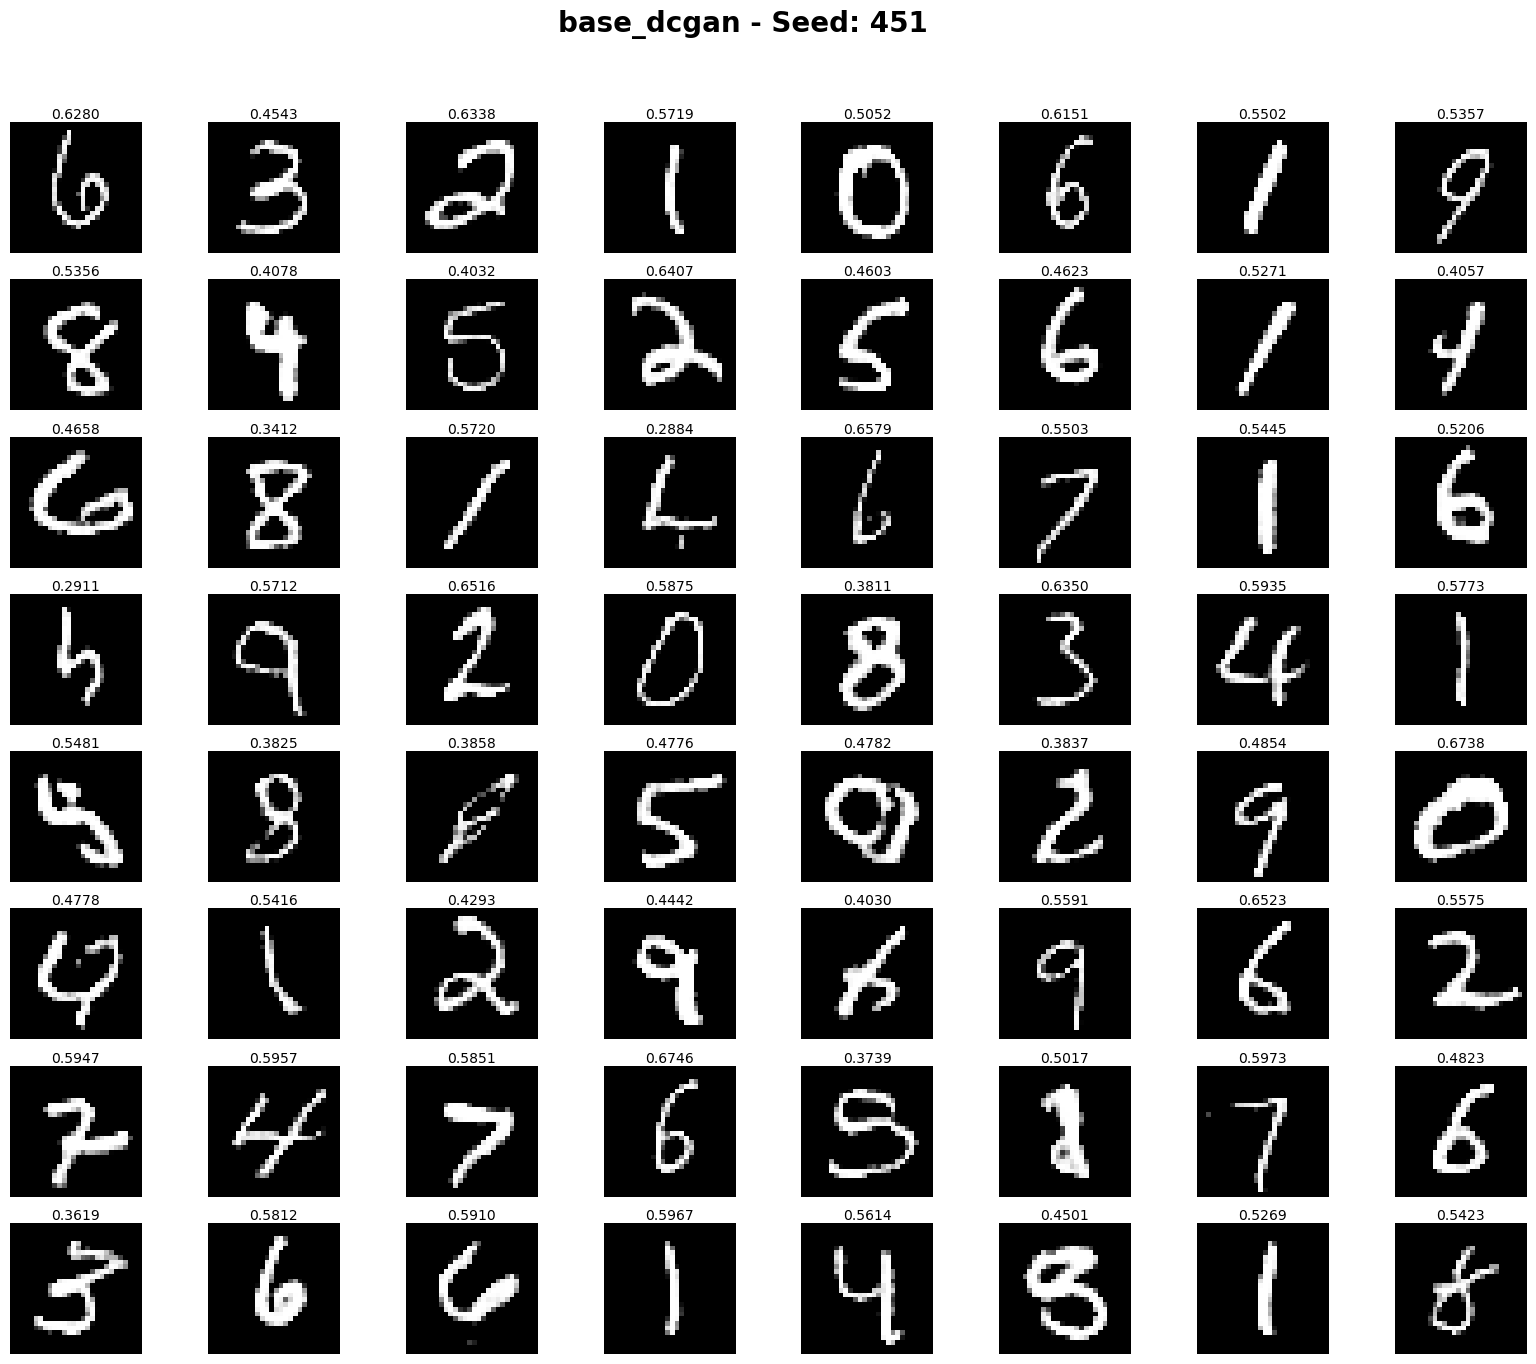

In [15]:
s = SEED
torch.manual_seed(s)
noise = (torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1)) 
generator.eval()
with torch.no_grad():
    gen = generator(noise)[0:64]
plot_res_64(gen.cpu().numpy(),
            nn.Sigmoid()(discriminator(gen)).reshape(-1).cpu().tolist(),
            MODEL_NAME+f" - Seed: {s}")
plt.savefig(f"{RESULT_DIR}/{s}", bbox_inches='tight')


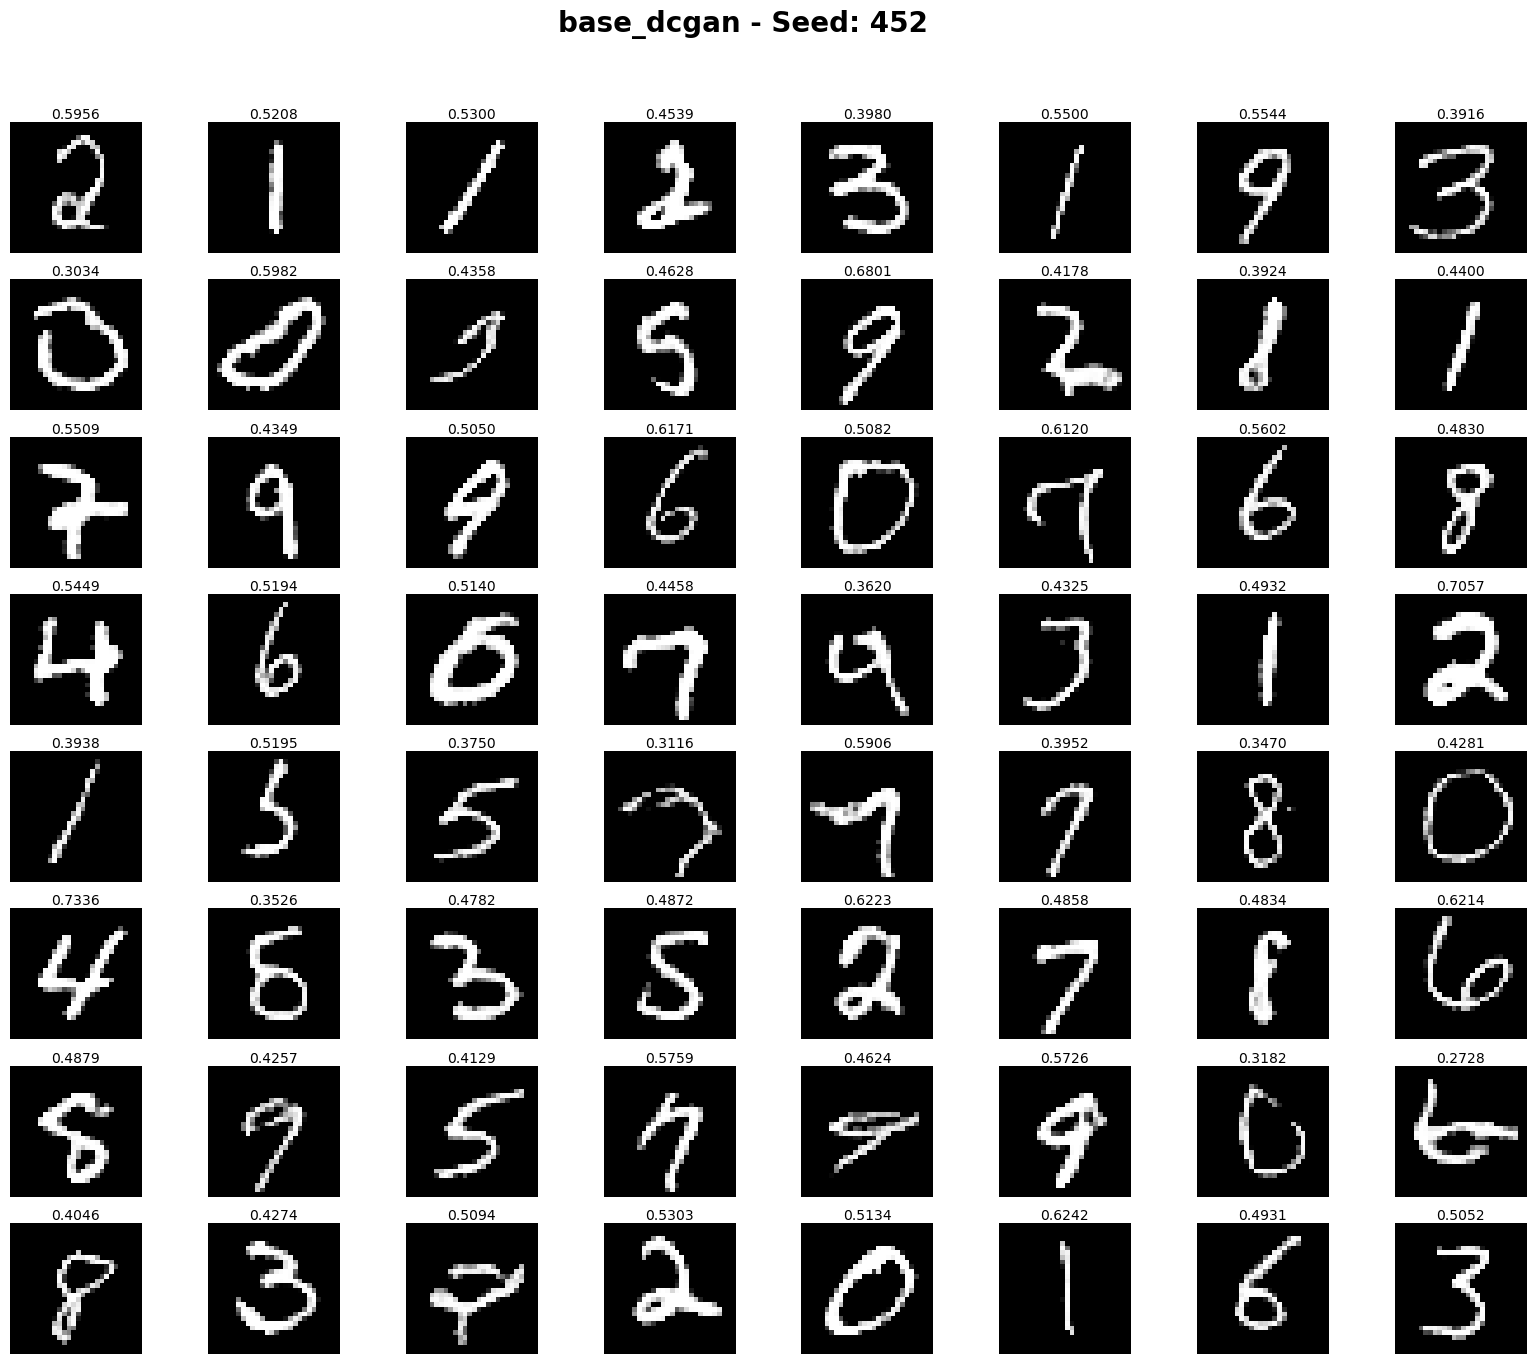

In [16]:
s += 1
torch.manual_seed(s)
noise = (torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1)) 
generator.eval()
with torch.no_grad():
    gen = generator(noise)[0:64]
plot_res_64(gen.cpu().numpy(),
            nn.Sigmoid()(discriminator(gen)).reshape(-1).cpu().tolist(),
            MODEL_NAME+f" - Seed: {s}")
plt.savefig(f"{RESULT_DIR}/{s}", bbox_inches='tight')

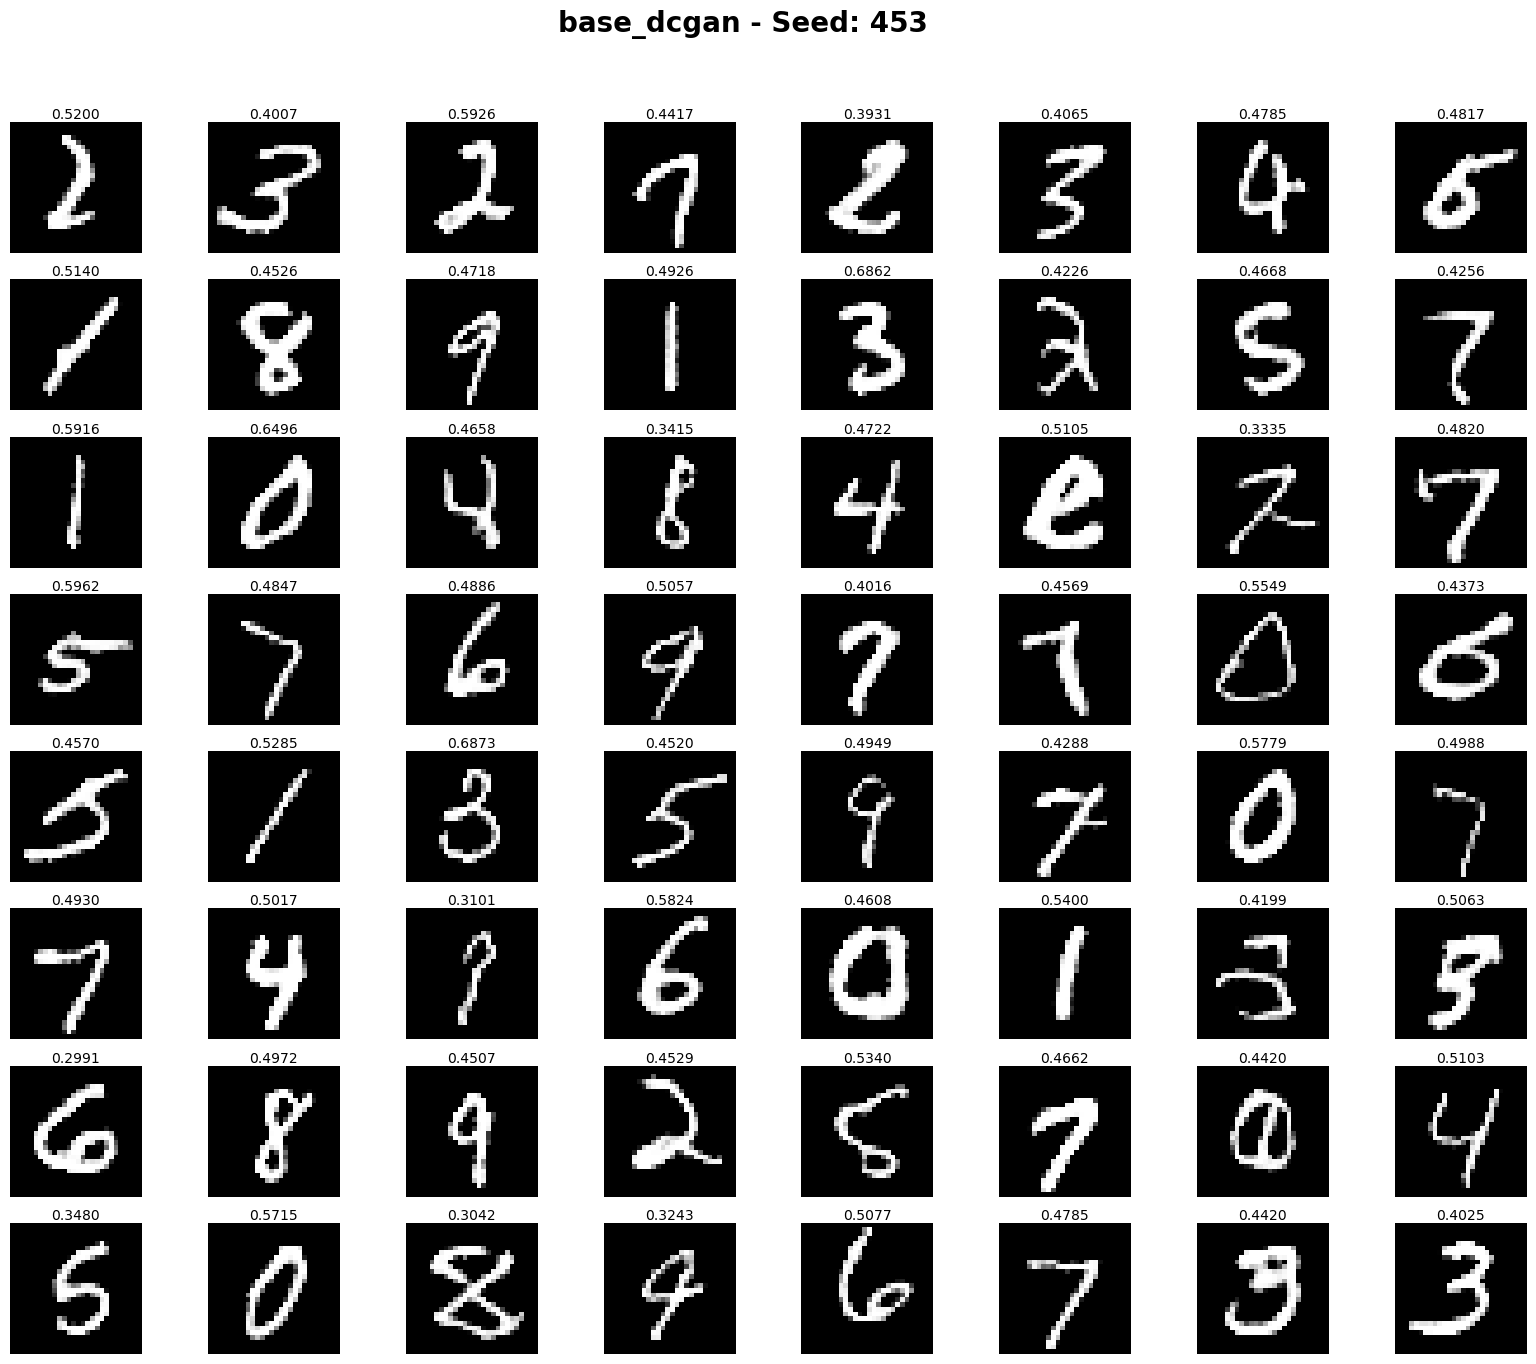

In [17]:
s += 1
torch.manual_seed(s)
noise = (torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1)) 
generator.eval()
with torch.no_grad():
    gen = generator(noise)[0:64]
plot_res_64(gen.cpu().numpy(),
            nn.Sigmoid()(discriminator(gen)).reshape(-1).cpu().tolist(),
            MODEL_NAME+f" - Seed: {s}")
plt.savefig(f"{RESULT_DIR}/{s}", bbox_inches='tight')

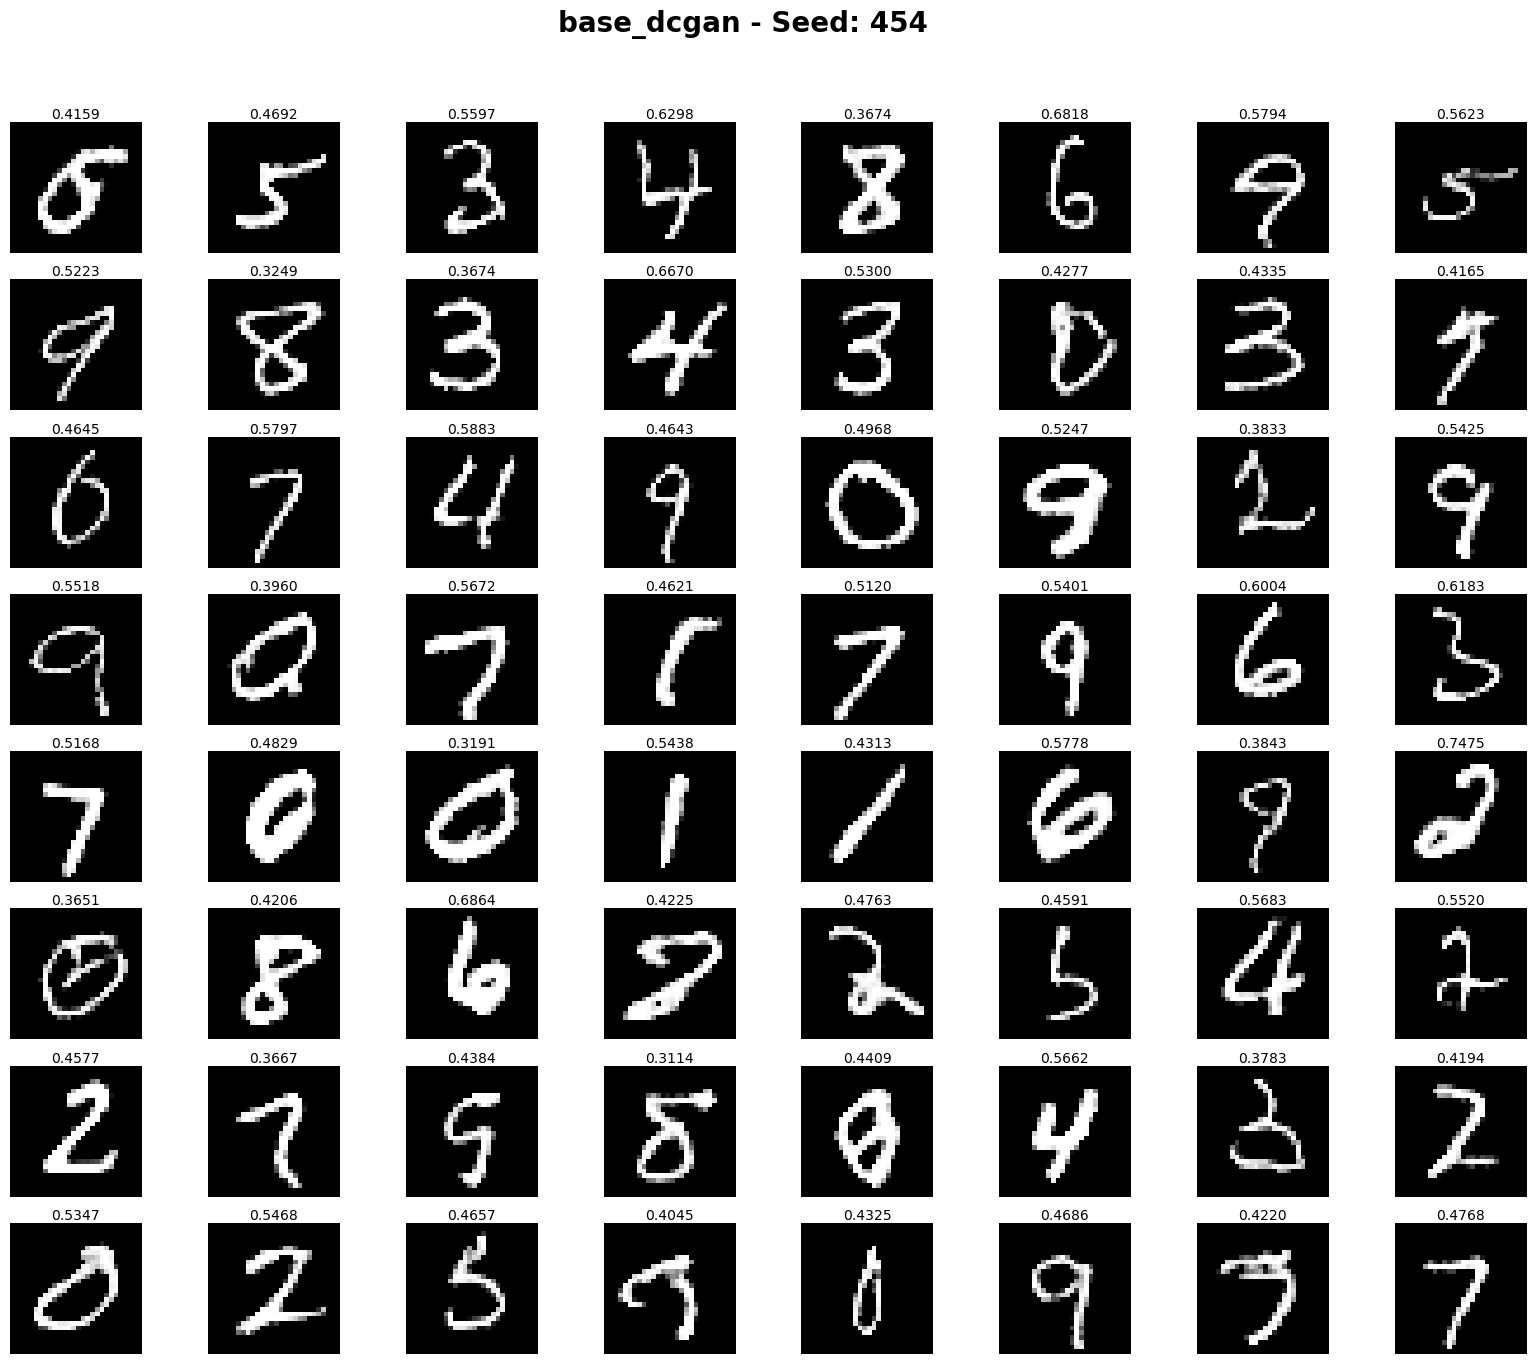

In [18]:
s += 1
torch.manual_seed(s)
noise = (torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1)) 
generator.eval()
with torch.no_grad():
    gen = generator(noise)[0:64]
plot_res_64(gen.cpu().numpy(),
            nn.Sigmoid()(discriminator(gen)).reshape(-1).cpu().tolist(),
            MODEL_NAME+f" - Seed: {s}")
plt.savefig(f"{RESULT_DIR}/{s}", bbox_inches='tight')